# Рекомендация тарифов

Оператор мобильной связи «Мегалайн» выяснил: многие клиенты пользуются архивными тарифами. Они хотят построить систему, способную проанализировать поведение клиентов и предложить пользователям новый тариф: «Смарт» или «Ультра».

Нужно построить модель для задачи классификации, которая выберет подходящий тариф. Предобработка данных не понадобится — вы её уже сделали.

**Цель исследования**:
Постройте модель с максимально большим значением *accuracy*. Чтобы сдать проект успешно, нужно довести долю правильных ответов по крайней мере до 0.75. Проверьте *accuracy* на тестовой выборке самостоятельно.

## Изучение общей информации

In [28]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix

In [29]:
user = pd.read_csv('datasets/users_behavior.csv')

In [30]:
user.head()

,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0


In [31]:
user.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


In [32]:
user.isna().mean()

calls       0.0
minutes     0.0
messages    0.0
mb_used     0.0
is_ultra    0.0
dtype: float64

In [33]:
user.duplicated().sum()

0

В работе рассматривается набор данных, состоящий из 3214 объектов с 5 признаками. Данные имеют типы int64, float. 
Пропусков нет, дубликатов тоже.
Известно:

- *сalls* — количество звонков,
- *minutes* — суммарная длительность звонков в минутах,
- *messages* — количество sms-сообщений,
- *mb_used* — израсходованный интернет-трафик в Мб,
- *is_ultra* — каким тарифом пользовался в течение месяца («Ультра» — 1, «Смарт» — 0).

## Разбиение данных на выборки

Чтобы получить тестовую выборку, разобъем данные в отношении 3:1:1.

In [34]:
user_train, user_valid = train_test_split(user, test_size=0.4, random_state=12345)
user_valid, user_test = train_test_split(user_valid, test_size=0.5, random_state=12345)

In [35]:
# обучающая выборка
features_train = user_train.drop(['is_ultra'], axis=1)
target_train = user_train['is_ultra']

In [36]:
# валидационная выборка
features_valid = user_valid.drop(['is_ultra'], axis=1)
target_valid = user_valid['is_ultra']

In [37]:
# тестовая выборка
features_test = user_test.drop(['is_ultra'], axis=1)
target_test = user_test['is_ultra']

## Исследование моделей

### DecisionTree

In [38]:
# словарь для хранения данных лучшей модели:
model_dict = {}

Для начала определим гиперпараметр решающего дерева:

In [39]:
best_tree_model = None
tree_best_result = 0
depth_tree = 0
for i in range(1, 11):
    model_tr = tree.DecisionTreeClassifier(criterion='entropy', random_state=12345, max_depth= i)
    model_tr.fit(features_train, target_train)
    predictions = model_tr.predict(features_valid)
    tree_result = accuracy_score(target_valid, predictions)
    if tree_result > tree_best_result:
        best_tree_model = model_tr
        tree_best_result = tree_result
        depth_tree = i
print('max_depth =', depth_tree)
print('Accuracy лучшей модели:', tree_best_result)

max_depth = 3
Accuracy лучшей модели: 0.7853810264385692


In [40]:
model_dict[tree_best_result] = 'DecisionTree', depth_tree

### RandomForest

Определим оптимальное число деревьев для модели Случайного леса.

In [41]:
best_forest_model = None
best_forest_result = 0
n_est = 0
for est in range(1,15):
    model_forest = RandomForestClassifier(random_state=12345, min_samples_split=2, n_estimators= est)
    model_forest.fit(features_train, target_train)
    forest_result = model_forest.score(features_valid, target_valid)
    if forest_result > best_forest_result:
        best_forest_model = model_forest
        best_forest_result = forest_result
        n_est = est
print('Число деревьев:', n_est)
print("Accuracy наилучшей модели на валидационной выборке:", best_forest_result)

Число деревьев: 12
Accuracy наилучшей модели на валидационной выборке: 0.7869362363919129


In [42]:
model_dict[best_forest_result] = 'RandomForest', n_est

### LogisticRegression

In [43]:
model_logistic = LogisticRegression(random_state=12345, solver='lbfgs', max_iter=1000)
model_logistic.fit(features_train, target_train)
logistic_result = model_logistic.score(features_valid, target_valid)
print('Accuracy logistic regression:', logistic_result)

Accuracy logistic regression: 0.7107309486780715


In [44]:
model_dict[logistic_result] = 'LogisticRegression', 1000

Из всех имеющихся моделей выберем ту, что имеет самое высокое качество и узнаем ее параметры:

In [45]:
print('Наилучшая модель:', model_dict.get(sorted(model_dict.keys())[-1]))

Наилучшая модель: ('RandomForest', 12)


*ВЫВОД*
Как показало исследование, наилучшее Accuracy имеет модель RandomForest с числом деревьев 12.

## Проверка модели на тестовой выборке

In [46]:
model = RandomForestClassifier(random_state=12345,min_samples_split=2, n_estimators=12)
model.fit(features_train, target_train)
predict_test = model.predict(features_test)
predict_train = model.predict(features_train)
accuracy_test = accuracy_score(target_test, predict_test)
accuracy_train = accuracy_score(target_train, predict_train)

In [47]:
print("Accuracy наилучшей модели на обучающей выборке:", accuracy_train)
print("Accuracy наилучшей модели на тестовой выборке:", accuracy_test)

Accuracy наилучшей модели на обучающей выборке: 0.983402489626556
Accuracy наилучшей модели на тестовой выборке: 0.7869362363919129


Проверка на тестовой выборке показала качество модели более 0,78.

## (бонус) Проверьте модели на адекватность

In [48]:
user['is_ultra'].mean()

0.30647168637212197

Как мы могли заметить, данные в нашей модели распределеные неравномерно. Accuracy в данном случае может быть необъективно.

Попробуем проверить адекватность модели бинарной крассификации с помощью Матрицы ошибок:

In [49]:
# Случайный лес
model_rfc = RandomForestClassifier(random_state=12345, n_estimators=12)
model_rfc.fit(features_train, target_train)
y_true = target_test
target_predict = model_rfc.predict(features_test)

<AxesSubplot:>

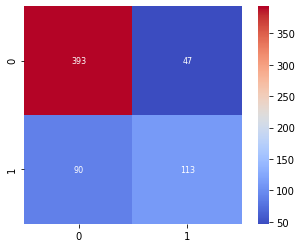

In [50]:
tn_fp_fn_tp = confusion_matrix(y_true, target_predict, labels=[0,1])
sns.heatmap(tn_fp_fn_tp, annot=True, annot_kws={"size": 8}, fmt='.3g', square=True, cmap='coolwarm')

Цель модели - максимизация диагональных показателей.

In [51]:
precision = precision_score(y_true, target_predict, pos_label=1)
precision

0.70625

Случайный лес с точностью в 70% случаев верно классифицирует пользователей тарифа Ультра.

In [52]:
recall = recall_score(y_true, target_predict, pos_label=1)
recall

0.5566502463054187

Recall демонстрирует способность алгоритма определять нужный класс - Ультра. Наша модель выделила лишь 55% объектов.

In [53]:
f1 = 2 *(recall * precision)/ (recall + precision)
f1

0.6225895316804407

Итак, качество модели чуть выше 62%. 